### Isolated American Sign Language Recognition Model
- Dataset used: GISLR

In [34]:
# Install missing dependencies
!pip install -q mediapipe tqdm

# Importing Libraries

In [35]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import mediapipe as mp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Enable Mixed Precision for faster training on Kaggle GPUs (T4/P100)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled")
except:
    print("Mixed precision skipped")

Mixed precision enabled


In [36]:
N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 42
NUM_CLASSES = 250
VERBOSE = 1

INPUT_SIZE = 64

BATCH_ALL_SIGNS_N = 4
BATCH_SIZE = 256
N_EPOCHS = 100
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05
MASK_VAL = 423

# Data Processing

In [37]:
train = pd.read_csv('/kaggle/input/asl-signs/train.csv')

In [38]:
train['sign_ord'] = train['sign'].astype('category').cat.codes

SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [39]:
train.head()

,path,participant_id,sequence_id,sign,sign_ord
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,25
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,232
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,23
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,164


In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
 4   sign_ord        94477 non-null  int16 
dtypes: int16(1), int64(2), object(2)
memory usage: 3.1+ MB


In [41]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [42]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])
LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0))
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((LIPS_IDXS0, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size
# Landmark indices in processed data
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()

print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')

# HAND_IDXS: 21, N_COLS: 66


In [43]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 61


In [44]:
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

        normalisation_correction = tf.constant(
            [
                [0] * len(LIPS_IDXS)
                + [0.50] * len(LEFT_HAND_IDXS)
                + [0.50] * len(POSE_IDXS),
                [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
            ],
            dtype=tf.float32,
        )

        self.normalisation_correction = tf.transpose(normalisation_correction, [1, 0])

    def pad_edge(self, t, repeats, side):
        def left():
            return tf.concat([tf.repeat(t[:1], repeats, axis=0), t], axis=0)

        def right():
            return tf.concat([t, tf.repeat(t[-1:], repeats, axis=0)], axis=0)

        return tf.cond(side == "LEFT", left, right)

    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None, N_ROWS, N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # number of frames
        n_frames0 = tf.shape(data0)[0]

        left_sum = tf.reduce_sum(
            tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0.0, 1.0)
        )
        right_sum = tf.reduce_sum(
            tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0.0, 1.0)
        )

        left_dominant = left_sum >= right_sum

        def left_frames():
            return tf.reduce_sum(
                tf.where(
                    tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)),
                    0.0,
                    1.0,
                ),
                axis=[1, 2],
            )

        def right_frames():
            return tf.reduce_sum(
                tf.where(
                    tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)),
                    0.0,
                    1.0,
                ),
                axis=[1, 2],
            )

        frames_non_nan = tf.cond(left_dominant, left_frames, right_frames)

        non_empty_idxs = tf.where(frames_non_nan > 0)[:, 0]
        data = tf.gather(data0, non_empty_idxs)

        non_empty_idxs = tf.cast(non_empty_idxs, tf.float32)
        non_empty_idxs -= tf.reduce_min(non_empty_idxs)

        def left_branch():
            return tf.gather(data, LANDMARK_IDXS_LEFT_DOMINANT0, axis=1)

        def right_branch():
            d = tf.gather(data, LANDMARK_IDXS_RIGHT_DOMINANT0, axis=1)
            return self.normalisation_correction + (
                (d - self.normalisation_correction)
                * tf.where(self.normalisation_correction != 0, -1.0, 1.0)
            )

        data = tf.cond(left_dominant, left_branch, right_branch)

        n_frames = tf.shape(data)[0]

        def pad_case():
            pad = INPUT_SIZE - n_frames
            return (
                tf.pad(data, [[0, pad], [0, 0], [0, 0]]),
                tf.pad(non_empty_idxs, [[0, pad]], constant_values=-1),
            )

        def sample_case():
            return data[:INPUT_SIZE], non_empty_idxs[:INPUT_SIZE]

        data, non_empty_idxs = tf.cond(n_frames < INPUT_SIZE, pad_case, sample_case)

        data = tf.where(tf.math.is_nan(data), 0.0, data)
        return data, non_empty_idxs


preprocess_layer = PreprocessLayer()


In [45]:
LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T

In [46]:
LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T

In [47]:
POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T

In [48]:
# --- REPLACEMENT DATA LOADER ---

# 1. Use the already loaded train DataFrame
train_df = train.copy()
# 'sign_ord' column is already added to 'train' DataFrame.

# 2. ROWS_PER_FRAME and INPUT_SIZE are already defined globally.

# 3. Helper function to read parquet and resize to 64 frames
def load_and_process_parquet(path):
    path = path.numpy().decode('utf-8')
    # Prepend the Kaggle dataset root as instructed
    path = f'/kaggle/input/asl-signs/{path}'

    try:
        # Read only coordinates
        df_parquet = pd.read_parquet(path, columns=['x', 'y', 'z'])
        data = df_parquet.values.reshape(-1, ROWS_PER_FRAME, 3)

        # Filter landmarks to the required 66 (N_COLS)
        data = data[:, LANDMARK_IDXS_LEFT_DOMINANT0, :]

        # Simple resize/sampling to INPUT_SIZE (64)
        if len(data) < INPUT_SIZE:
            # Pad with zeros if too short, using N_COLS for the landmark dimension
            pad = np.zeros((INPUT_SIZE - len(data), N_COLS, 3), dtype=np.float32)
            data = np.concatenate([data, pad], axis=0)
        elif len(data) > INPUT_SIZE:
            # Uniform sample if too long
            indices = np.linspace(0, len(data)-1, INPUT_SIZE, dtype=int)
            data = data[indices]

        data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
        return data.astype(np.float32)
    except Exception as e:
        print(f"Error loading {path}: {e}")
        # Return a zero array for failed loads to keep batching consistent
        return np.zeros((INPUT_SIZE, N_COLS, 3), dtype=np.float32)


# 4. TensorFlow Wrapper
def tf_load_parquet(path, label):
    X = tf.py_function(load_and_process_parquet, [path], tf.float32)
    X.set_shape([INPUT_SIZE, N_COLS, 3])

    # Dummy but valid frame indices (0..63)
    valid_idxs = tf.range(INPUT_SIZE, dtype=tf.float32)

    # 🔴 FIX: one-hot encode labels
    label = tf.one_hot(tf.cast(label, tf.int32), depth=NUM_CLASSES)


    return {
        'frames': X,
        'non_empty_frame_idxs': valid_idxs
    }, label


# 5. Create Dataset Object
def get_dataset(df, batch_size=None, shuffle=True):
    # Ensure batch_size defaults to BATCH_SIZE if not provided
    if batch_size is None:
        batch_size = BATCH_SIZE

    paths = df['path'].values
    labels = df['sign_ord'].values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=5000)

    # Map the loading function (parallelized)
    ds = ds.map(tf_load_parquet, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# Create the datasets
# We assume the whole train_df is training data for now
train_ds = get_dataset(train_df, batch_size=BATCH_SIZE)

print("✅ Data Pipeline created successfully")

✅ Data Pipeline created successfully


In [49]:
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=BATCH_ALL_SIGNS_N):
    # Arrays to store batch in
    X_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE], dtype=np.float32)

    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)

    while True:
        # Fill batch arrays
        for i in range(NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            X_batch[i*n:(i+1)*n] = X[idxs]
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = NON_EMPTY_FRAME_IDXS[idxs]

        yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

In [50]:
for x, y in train_ds.take(1):
    print(x["frames"].shape)
    print(x["non_empty_frame_idxs"].shape)
    print(y.shape)
    print(y.dtype)


(256, 64, 66, 3)
(256, 64)
(256, 250)
<dtype: 'float32'>


# Transformer

In [51]:
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 512

# Transformer
NUM_BLOCKS = 2
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

print(f'UNITS: {UNITS}')

UNITS: 512


In [52]:
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)

    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()

    def call(self,x, attention_mask):

        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))

        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [53]:
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks

    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 8))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))

    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for mha, mlp in zip(self.mhas, self.mlps):
            x = x + mha(x, attention_mask)
            x = x + mlp(x)

        return x

In [54]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units

    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

In [55]:
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()

    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, INPUT_SIZE, S*S])
        return diffs

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)
        # Embedding layer for Landmarks
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([3], dtype=tf.float32), name='landmark_weights')
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')


    def call(self, lips0, left_hand0, pose0, non_empty_frame_idxs, training=False):
        # Lips
        lips_embedding = self.lips_embedding(lips0)
        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Pose
        pose_embedding = self.pose_embedding(pose0)
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((
            lips_embedding, left_hand_embedding, pose_embedding,
        ), axis=3)
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layers
        x = self.fc(x)
        # Add Positional Embedding
        max_frame_idxs = tf.clip_by_value(
                tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True),
                1,
                np.PINF,
            )
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / max_frame_idxs * INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)

        return x

In [56]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input(
        shape=(INPUT_SIZE, N_COLS, N_DIMS),
        dtype=tf.float32,
        name="frames",
    )

    non_empty_frame_idxs = tf.keras.layers.Input(
        shape=(INPUT_SIZE,),
        dtype=tf.float32,
        name="non_empty_frame_idxs",
    )

    # Padding mask (Keras-safe)
    mask0 = FrameMask()(non_empty_frame_idxs)  # (B, T, 1)

    # --------------------------------------------------
    # Example: random frame masking (if you had it)
    # --------------------------------------------------
    # mask0 = SomeMaskingLayer()(mask0)

    # --------------------------------------------------
    # Flatten spatial dims
    # --------------------------------------------------
    x = tf.keras.layers.Reshape(
        (INPUT_SIZE, N_COLS * N_DIMS)
    )(frames)

    # --------------------------------------------------
    # Projection
    # --------------------------------------------------
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.LayerNormalization()(x)

    # --------------------------------------------------
    # Transformer block (example)
    # --------------------------------------------------
    attn = tf.keras.layers.MultiHeadAttention(
        num_heads=4,
        key_dim=64,
        dropout=0.1,
    )(x, x, attention_mask=mask0)

    x = tf.keras.layers.Add()([x, attn])
    x = tf.keras.layers.LayerNormalization()(x)

    # --------------------------------------------------
    # Pooling (mask-aware)
    # --------------------------------------------------
    mask_sum = tf.keras.layers.Lambda(
        lambda m: tf.reduce_sum(m, axis=1) + 1e-6
    )(mask0)

    x = tf.keras.layers.Lambda(
        lambda args: tf.reduce_sum(args[0] * args[1], axis=1)
        / args[2]
    )([x, mask0, mask_sum])

    # --------------------------------------------------
    # Head
    # --------------------------------------------------
    x = tf.keras.layers.Dense(256, activation="gelu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    outputs = tf.keras.layers.Dense(
        NUM_CLASSES, activation="softmax"
    )(x)

    model = tf.keras.Model(
        inputs=[frames, non_empty_frame_idxs],
        outputs=outputs,
    )

    return model


In [57]:
class FrameMask(tf.keras.layers.Layer):
    """
    Converts non_empty_frame_idxs into a padding mask.
    -1 → padded
    >=0 → valid frame
    """
    def call(self, x):
        # x shape: (B, INPUT_SIZE)
        mask = tf.cast(tf.not_equal(x, -1), tf.float32)
        # (B, INPUT_SIZE, 1)
        return tf.expand_dims(mask, axis=-1)


In [58]:
model = get_model()

In [59]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ frames (InputLayer) │ (None, 64, 66, 3) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 64, 198)   │          0 │ frames[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64, 256)   │     50,944 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ non_empty_frame_id… │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 256)   │        512 │ dense_3[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ frame_mask_1        │ (None, 64, 1)     │          0 │ non_empty_frame_… │
│ (FrameMask)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 256)   │    263,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ frame_mask_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 256)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 256)   │        512 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1)         │          0 │ frame_mask_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 256)       │          0 │ layer_normalizat… │
│                     │                   │            │ frame_mask_1[0][… │
│                     │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 250)       │     64,250 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 445,178 (1.70 MB)

 Trainable params: 445,178 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

## Learning Rate Scheduling

In [60]:
import math
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    WARMUP_METHOD = 'log'
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

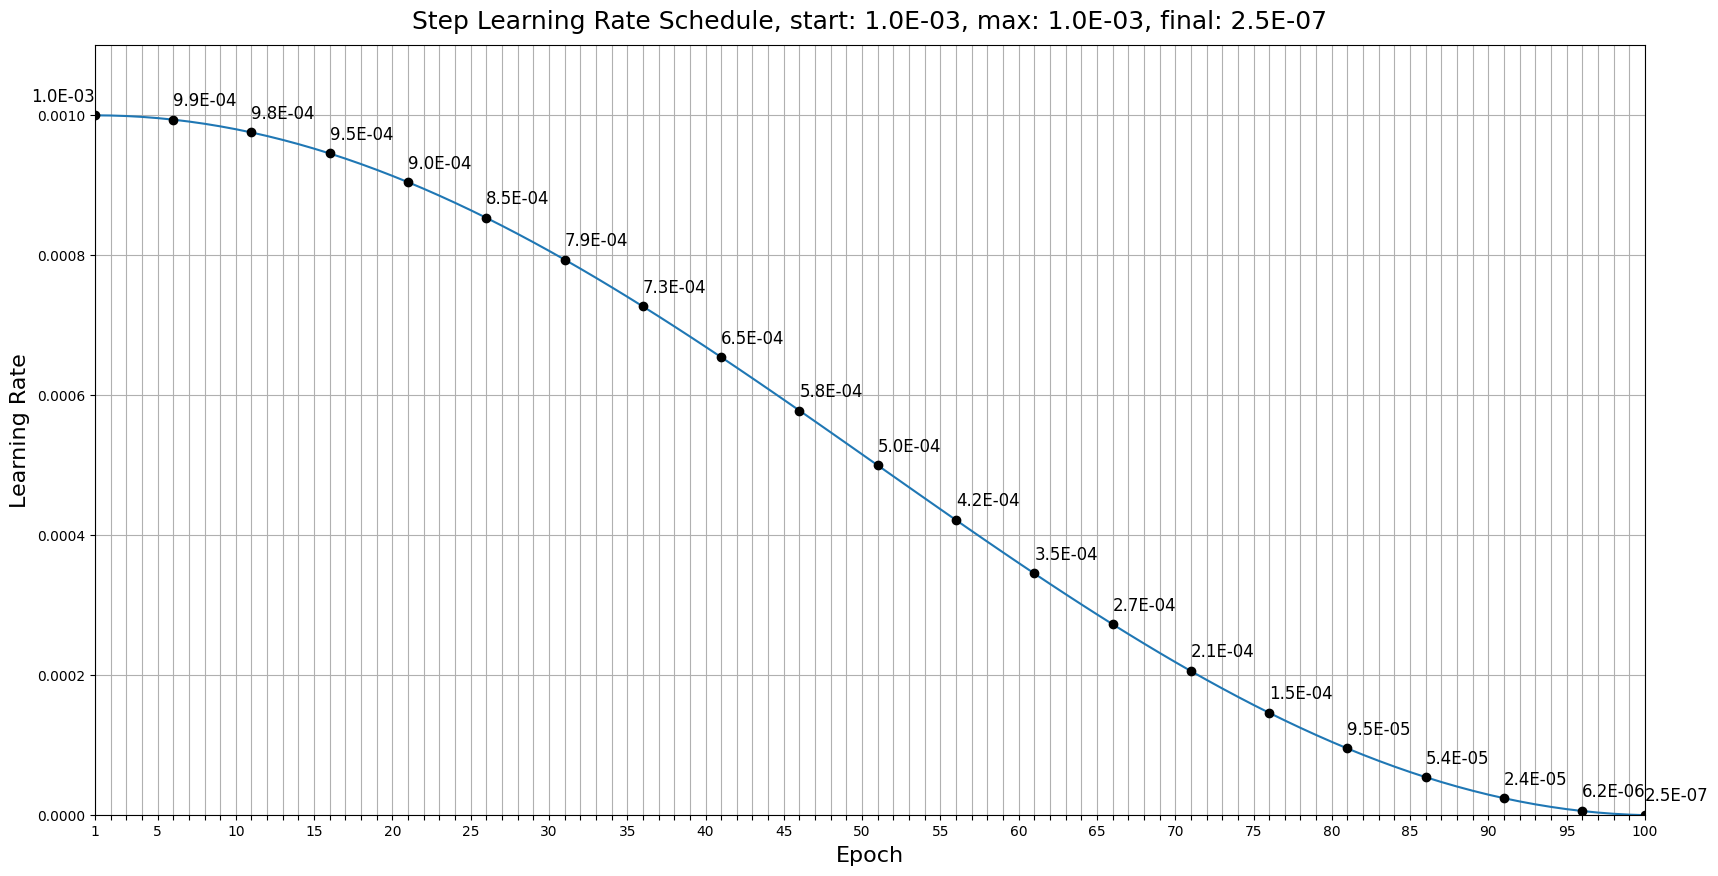

In [61]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1

    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])

    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)

    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)

    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

## Weight Decay Callback

In [62]:
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio

    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

## Training

In [63]:
# =========================
# OPTIMIZER + LOSS (FINAL, CLEAN)
# =========================

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 5e-5  # matches your log
LABEL_SMOOTHING = 0.25

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Native, stable loss (NO custom ops)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=LABEL_SMOOTHING
)


In [64]:
for x, y in train_ds.take(1):
    print(x["frames"].shape)
    print(x["non_empty_frame_idxs"].shape)
    print(y.shape)


(256, 64, 66, 3)
(256, 64)
(256, 250)


In [65]:
for x, y in train_ds.take(1):
    print(np.isnan(x["frames"].numpy()).any())
    print(np.isnan(y.numpy()).any())


False
False


In [ ]:
# --- UPDATED TRAINING CELL ---

# Re-compile model to ensure optimizer is fresh (Optional but recommended)
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=["accuracy"]
)

# Train
history = model.fit(
    train_ds,
    epochs=N_EPOCHS,
    callbacks=[
        lr_callback,
        WeightDecayCallback(),
        # Add checkpointing to save progress
        tf.keras.callbacks.ModelCheckpoint('model.weights.h5', save_best_only=True, save_weights_only=True, monitor='loss')
    ],
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
learning rate: 1.00e-03, weight decay: 5.00e-05
Epoch 1/100
 69/370 ━━━━━━━━━━━━━━━━━━━━ 3:51 769ms/step - accuracy: 0.0034 - loss: 5.5707

# Accuracy and Loss Curves

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss vs epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Making TFLite Model

In [ ]:
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.model = model

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, N_ROWS, N_DIMS], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        # Preprocess Data
        x, non_empty_frame_idxs = self.preprocess_layer(inputs)
        # Add Batch Dimension
        x = tf.expand_dims(x, axis=0)
        non_empty_frame_idxs = tf.expand_dims(non_empty_frame_idxs, axis=0)
        # Make Prediction
        outputs = self.model({ 'frames': x, 'non_empty_frame_idxs': non_empty_frame_idxs })
        # Squeeze Output 1x250 -> 250
        outputs = tf.squeeze(outputs, axis=0)

        # Return a dictionary with the output tensor
        return {'outputs': outputs}


In [ ]:
tflite_keras_model = TFLiteModel(model)

In [ ]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
# Convert Model
tflite_model = keras_model_converter.convert()
# Write Model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Testing Environment

In [ ]:
import cv2
import mediapipe as mp
import pandas as pd
import numpy as np
import time
import tensorflow as tf
import google.generativeai as genai

In [ ]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
pred_fn = interpreter.get_signature_runner("serving_default")

In [ ]:
train = pd.read_csv("train.csv")

train['sign_ord'] = train['sign'].astype('category').cat.codes

SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

unique_signs = []

In [ ]:
def create_frame_landmark_df(results, frame, xyz):
    xyz_skel = (xyz[["type", "landmark_index"]].drop_duplicates().reset_index(drop=True).copy())
    face = pd.DataFrame()
    pose = pd.DataFrame()
    left_hand = pd.DataFrame()
    right_hand = pd.DataFrame()

    if results.face_landmarks:
        for i, point in enumerate(results.face_landmarks.landmark):
            face.loc[i, ["x", "y", "z"]] = [point.x, point.y, point.z]
    if results.pose_landmarks:
        for i, point in enumerate(results.pose_landmarks.landmark):
            pose.loc[i, ["x", "y", "z"]] = [point.x, point.y, point.z]
    if results.left_hand_landmarks:
        for i, point in enumerate(results.left_hand_landmarks.landmark):
            left_hand.loc[i, ["x", "y", "z"]] = [point.x, point.y, point.z]
    if results.right_hand_landmarks:
        for i, point in enumerate(results.right_hand_landmarks.landmark):
            right_hand.loc[i, ["x", "y", "z"]] = [point.x, point.y, point.z]

    face = face.reset_index().rename(columns={"index": "landmark_index"}).assign(type="face")
    pose = pose.reset_index().rename(columns={"index": "landmark_index"}).assign(type="pose")
    left_hand = left_hand.reset_index().rename(columns={"index": "landmark_index"}).assign(type="left_hand")
    right_hand = right_hand.reset_index().rename(columns={"index": "landmark_index"}).assign(type="right_hand")

    landmarks = pd.concat([face, pose, left_hand, right_hand]).reset_index(drop=True)
    landmarks = xyz_skel.merge(landmarks, on=["type", "landmark_index"], how="left").assign(frame=frame)

    return landmarks

In [ ]:
from dotenv import load_dotenv
import os
load_dotenv()

def get_display_message_from_api(recognised_words):

    GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
    genai.configure(api_key=GOOGLE_API_KEY)

    model = genai.GenerativeModel('gemini-pro')

    prompt = f"""
            Objective:
            You have developed an isolated American Sign Language (ASL) word recognition model. At the end of each run, the model stores the recognized words in a list. However, the words may not necessarily be in the correct order. Your objective is to utilize these recognized words to construct a coherent and meaningful English sentence. The resulting sentence should be as simple as possible while still accurately conveying the intended meaning.

            Instructions:

            - Input: You will be provided with a Python list containing the recognized ASL words from your model. The contents of this list may vary depending on the output of your model.
            - Processing: Rearrange the words in the list to form a grammatically correct and logically relevant English sentence. Take into consideration the context and logical flow of the sentence. Always ignore the word "TV".
            - Output: Generate a concise English sentence that accurately conveys the meaning of the recognized ASL words.

            Considerations:

            - Simplicity: Aim for simplicity in your sentence structure and vocabulary.
            - Clarity: Ensure that the sentence is clear and understandable.
            - Relevance: The sentence should reflect the meaning conveyed by the ASL words.
            - Grammar: Maintain proper grammar and syntax in the sentence.

            Example:

            Input: recognized_words = cat mat
            output: cat on the mat

            Here is the actual input for which you have to produce the relevant output: recognised_words = {' '.join(recognised_words)}
            """

    response = model.generate_content(prompt)

    return response.text

In [ ]:
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    ROWS_PER_FRAME = 543
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

def do_capture_loop(xyz, pred_fn):
    all_landmarks = []
    cap = cv2.VideoCapture(0)
    start_time = time.time()
    font = cv2.FONT_HERSHEY_SIMPLEX
    last_prediction_time = -5
    escape_pressed = False
    display_message = "Press Escape to toggle message display"
    unique_signs = []
    sign_name = ""

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            current_time = time.time()
            elapsed_time = int(current_time - start_time)

            success, image = cap.read()
            if not success:
                print("Ignoring empty camera frame.")
                continue

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = holistic.process(image)
            landmarks = create_frame_landmark_df(results, elapsed_time, xyz)
            all_landmarks.append(landmarks)

            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            mp_drawing.draw_landmarks(
                image,
                results.face_landmarks,
                mp_holistic.FACEMESH_CONTOURS,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style()
            )
            mp_drawing.draw_landmarks(
                image,
                results.pose_landmarks,
                mp_holistic.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()
            )

            if current_time - last_prediction_time >= 5:
                if all_landmarks:
                    concatenated_landmarks = pd.concat(all_landmarks).reset_index(drop=True)
                    concatenated_landmarks.to_parquet("out.parquet")
                    xyz_np = load_relevant_data_subset("out.parquet")
                    p = pred_fn(inputs=xyz_np)
                    sign = p['outputs'].argmax()
                    sign_name = ORD2SIGN[sign]
                    pc = p['outputs'][sign]
                    if sign_name not in unique_signs:
                        unique_signs.append(sign_name)

                    last_prediction_time = current_time
                    all_landmarks = []  # Reset landmarks

            if sign_name == "":
                sign_name = "No Movement Detected"

            cv2.putText(image, f"Sign: {sign_name}", (10, 80), font, 2, (0, 255, 0), 3, cv2.LINE_AA)
            cv2.putText(image, f"Time: {elapsed_time}s", (10, 150), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

            if escape_pressed:
                cv2.putText(image, display_message, (10, 200), font, 1, (0, 0, 255), 2, cv2.LINE_AA)

            cv2.imshow("MediaPipe Holistic", image)

            key = cv2.waitKey(5)
            if key & 0xFF == 27:  # Escape key
                escape_pressed = not escape_pressed
                display_message = get_display_message_from_api(unique_signs) if escape_pressed else "Press Escape to toggle message display"
                if escape_pressed:
                    unique_signs = []
            elif key & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

pq_file = "10042041.parquet"
xyz = pd.read_parquet(pq_file)
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
pred_fn = interpreter.get_signature_runner("serving_default")

landmarks = do_capture_loop(xyz, pred_fn)

# Visualisation

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
path_to_sign = 'output_every_5s.parquet'
sign = pd.read_parquet(path_to_sign)
sign.y = sign.y * -1

In [ ]:
def get_hand_points(hand):
    x = [[hand.iloc[0].x, hand.iloc[1].x, hand.iloc[2].x, hand.iloc[3].x, hand.iloc[4].x], # Thumb
         [hand.iloc[5].x, hand.iloc[6].x, hand.iloc[7].x, hand.iloc[8].x], # Index
         [hand.iloc[9].x, hand.iloc[10].x, hand.iloc[11].x, hand.iloc[12].x],
         [hand.iloc[13].x, hand.iloc[14].x, hand.iloc[15].x, hand.iloc[16].x],
         [hand.iloc[17].x, hand.iloc[18].x, hand.iloc[19].x, hand.iloc[20].x],
         [hand.iloc[0].x, hand.iloc[5].x, hand.iloc[9].x, hand.iloc[13].x, hand.iloc[17].x, hand.iloc[0].x]]

    y = [[hand.iloc[0].y, hand.iloc[1].y, hand.iloc[2].y, hand.iloc[3].y, hand.iloc[4].y],  #Thumb
         [hand.iloc[5].y, hand.iloc[6].y, hand.iloc[7].y, hand.iloc[8].y], # Index
         [hand.iloc[9].y, hand.iloc[10].y, hand.iloc[11].y, hand.iloc[12].y],
         [hand.iloc[13].y, hand.iloc[14].y, hand.iloc[15].y, hand.iloc[16].y],
         [hand.iloc[17].y, hand.iloc[18].y, hand.iloc[19].y, hand.iloc[20].y],
         [hand.iloc[0].y, hand.iloc[5].y, hand.iloc[9].y, hand.iloc[13].y, hand.iloc[17].y, hand.iloc[0].y]]
    return x, y

def get_pose_points(pose):
    x = [[pose.iloc[8].x, pose.iloc[6].x, pose.iloc[5].x, pose.iloc[4].x, pose.iloc[0].x, pose.iloc[1].x, pose.iloc[2].x, pose.iloc[3].x, pose.iloc[7].x],
         [pose.iloc[10].x, pose.iloc[9].x],
         [pose.iloc[22].x, pose.iloc[16].x, pose.iloc[20].x, pose.iloc[18].x, pose.iloc[16].x, pose.iloc[14].x, pose.iloc[12].x,
          pose.iloc[11].x, pose.iloc[13].x, pose.iloc[15].x, pose.iloc[17].x, pose.iloc[19].x, pose.iloc[15].x, pose.iloc[21].x],
         [pose.iloc[12].x, pose.iloc[24].x, pose.iloc[26].x, pose.iloc[28].x, pose.iloc[30].x, pose.iloc[32].x, pose.iloc[28].x],
         [pose.iloc[11].x, pose.iloc[23].x, pose.iloc[25].x, pose.iloc[27].x, pose.iloc[29].x, pose.iloc[31].x, pose.iloc[27].x],
         [pose.iloc[24].x, pose.iloc[23].x]
        ]

    y = [[pose.iloc[8].y, pose.iloc[6].y, pose.iloc[5].y, pose.iloc[4].y, pose.iloc[0].y, pose.iloc[1].y, pose.iloc[2].y, pose.iloc[3].y, pose.iloc[7].y],
         [pose.iloc[10].y, pose.iloc[9].y],
         [pose.iloc[22].y, pose.iloc[16].y, pose.iloc[20].y, pose.iloc[18].y, pose.iloc[16].y, pose.iloc[14].y, pose.iloc[12].y,
          pose.iloc[11].y, pose.iloc[13].y, pose.iloc[15].y, pose.iloc[17].y, pose.iloc[19].y, pose.iloc[15].y, pose.iloc[21].y],
         [pose.iloc[12].y, pose.iloc[24].y, pose.iloc[26].y, pose.iloc[28].y, pose.iloc[30].y, pose.iloc[32].y, pose.iloc[28].y],
         [pose.iloc[11].y, pose.iloc[23].y, pose.iloc[25].y, pose.iloc[27].y, pose.iloc[29].y, pose.iloc[31].y, pose.iloc[27].y],
         [pose.iloc[24].y, pose.iloc[23].y]
        ]
    return x, y

In [ ]:
def animation_frame(f):
    frame = sign[sign.frame==f]
    left = frame[frame.type=='left_hand']
    right = frame[frame.type=='right_hand']
    pose = frame[frame.type=='pose']
    face = frame[frame.type=='face'][['x', 'y']].values
    lx, ly = get_hand_points(left)
    rx, ry = get_hand_points(right)
    px, py = get_pose_points(pose)
    ax.clear()
    ax.plot(face[:,0], face[:,1], '.')
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    for i in range(len(rx)):
        ax.plot(rx[i], ry[i])
    for i in range(len(px)):
        ax.plot(px[i], py[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

## These values set the limits on the graph to stabilize the video
xmin = sign.x.min() - 0.2
xmax = sign.x.max() + 0.2
ymin = sign.y.min() - 0.2
ymax = sign.y.max() + 0.2

fig, ax = plt.subplots()
l, = ax.plot([], [])
animation = FuncAnimation(fig, func=animation_frame, frames=sign.frame.unique())

HTML(animation.to_html5_video())